<a href="https://colab.research.google.com/github/Camilarcila/Entregas-de-proyectos_Camila-Arcila/blob/main/03%20-%20Modelos%20e%20iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importar Dependencias

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from progressbar import progressbar as pbar
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')

#2. Importar datos procesados desde Github

In [94]:
url = 'https://raw.githubusercontent.com/AlexBedCarIA/IA_project_Alexander_Bedoya/main/datos_proyecto_procesados.csv'
d = pd.read_csv(url)

In [95]:
df = d.copy()

#3. Métodos supervisados

### 3.1 Partición de los datos

In [96]:
cols_poca_corr = ['vehicleDestroys',
 'numGroups',
 'roadKills',
 'maxPlace',
 'rankPoints',
 'teamKills',
 'killPoints',
 'winPoints',
 'matchDuration']


In [ ]:
df2 = df[[col for col in df.columns if col!='matchType']][:2000000]
df2 = df2[[col for col in df2.columns if col not in cols_poca_corr]]

In [97]:
df2 = df[[col for col in df.columns if col!='matchType']]

In [98]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   assists          200000 non-null  int64  
 1   boosts           200000 non-null  int64  
 2   damageDealt      200000 non-null  float64
 3   DBNOs            200000 non-null  int64  
 4   headshotKills    200000 non-null  int64  
 5   heals            200000 non-null  int64  
 6   killPlace        200000 non-null  int64  
 7   killPoints       200000 non-null  int64  
 8   kills            200000 non-null  int64  
 9   killStreaks      200000 non-null  int64  
 10  longestKill      200000 non-null  float64
 11  matchDuration    200000 non-null  int64  
 12  maxPlace         200000 non-null  int64  
 13  numGroups        200000 non-null  int64  
 14  rankPoints       200000 non-null  int64  
 15  revives          200000 non-null  int64  
 16  rideDistance     200000 non-null  floa

In [ ]:
X = df2.drop(['winPlacePerc'],axis = 1).values
y = df2['winPlacePerc'].values

In [127]:
from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size)

print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(200000, 24) (200000,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(140000, 24) (60000, 24)


###3.2 Selección de modelos

In [100]:
def report_cv_score(z):
    print ("MAE test   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]*(-1)), np.std(z["test_score"]), len(z["test_score"])))
    print ("MAE train  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]*(-1)), np.std(z["train_score"]), len(z["train_score"])))

Se usarán 3 estimadores, de los cuales se escogerán los 2 con mejor rendimiento para encontrar los mejores hiperparámetros, correrlos con estos y quedarse con el que tenga mejor rendimiento, en este caso, un mejor [MAE](https://es.wikipedia.org/wiki/Error_absoluto_medio).

In [101]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [109]:
zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print('\n---------', estimator, '----------\n')
    z = cross_validate(estimator, Xtv, ytv, 
                       return_train_score=True, return_estimator=False,
                       scoring='neg_mean_absolute_error', 
                       cv=ShuffleSplit(n_splits=10, test_size=val_size))
    
    report_cv_score(z)
    zscores.append(np.abs(np.mean(z["test_score"])))

best = np.argmin(zscores)
print ("\nSeleccionado:", best+1)
best_estimator = estimators[best]
print ("\nModelo seleccionado:")
print (best_estimator)


--------- LinearRegression() ----------

MAE test   0.098 (±0.0002) with 10 splits
MAE train  0.098 (±0.0002) with 10 splits

--------- DecisionTreeRegressor(max_depth=5) ----------

MAE test   0.093 (±0.0007) with 10 splits
MAE train  0.093 (±0.0007) with 10 splits

--------- RandomForestRegressor(max_depth=5, n_estimators=2) ----------

MAE test   0.092 (±0.0010) with 10 splits
MAE train  0.092 (±0.0009) with 10 splits

Seleccionado: 3

Modelo seleccionado:
RandomForestRegressor(max_depth=5, n_estimators=2)


Los modelos con mejor rendimiento fueron el DecisionThreeRegressor y el RandomForestRegresor, así que estos será con los que se trabajará.

###3.3 Encontrar mejores parámetros

Se usará la herramienta de la libreria Scikit-Learn que permite analizar diferentes parámetros para un modelo con el fin de obtener la mejor selección de los mismos y obtener un modelo más robusto. Esta heramient utiliza una metodología de cross-validation y se le puede brindar un diccionario con diferentes valores para cada hiperparámetros y así hallar cual es la mejor opción.

In [103]:
from sklearn.model_selection import GridSearchCV

3.3.1 Hiperparámetros para Decision Three Regressor

In [117]:
parametros = {'max_depth': [5,10,15,20,25]}

decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_absolute_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
decission_tree.fit(Xtv, ytv)

print("\nMejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Des_tree = decission_tree.best_estimator_
Des_tree.fit(Xtv, ytv)

print('\nMAE del Decision Tree en entrenamiento: ',"{:.5f}".format(mean_absolute_error(ytv, Des_tree.predict(Xtv))))
print('MAE del Decision Tree seleccionado: ',"{:.5f}".format(mean_absolute_error(yts , Des_tree.predict(Xts))))

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=10)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 10}

MAE del Decision Tree en entrenamiento:  0.07188
MAE del Decision Tree seleccionado:  0.07467


3.3.2 Hiperparámetros para Random Forest Regresor

In [118]:
parametros = { 'n_estimators': [5,10,15,20,25],
              'max_depth':[5,10,15,20,25]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_absolute_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

print("\nMejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Rdm_forest = forest_reg.best_estimator_
Rdm_forest.fit(Xtv, ytv)

print('\nMAE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_absolute_error(ytv, (Rdm_forest.predict(Xtv)))))
print('MAE del Random Forest seleccionado: ',"{:.5f}".format(mean_absolute_error(yts , Rdm_forest.predict(Xts))))

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=15, n_estimators=25)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 15, 'n_estimators': 25}

MAE del Random Forest en entrenamiento:  0.04873
MAE del Random Forest seleccionado:  0.06452


#4. Métodos no supervisados

### 4.1 PCA

####4.1.1 Partición de los datos

In [119]:
X2 = df2.drop(['winPlacePerc'],axis = 1)
y2 = df2['winPlacePerc'].values

In [121]:
from sklearn.decomposition import PCA
components = [5,10,15,20]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = []
Rdm_forest = RandomForestRegressor(n_estimators = 20,max_depth = 15)
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(X2)
    
    Xtv, Xts, ytv, yts = train_test_split(X_t, y2, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf.append(mean_absolute_error(yts , Rdm_forest.predict(Xts)))
    print('MAE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_absolute_error(yts , Rdm_forest.predict(Xts))))
    print('------------')

print('Mejor MAE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')

(140000, 5) (60000, 5)
MAE del modelo con  5 elementos:  0.11355
------------
(140000, 10) (60000, 10)
MAE del modelo con  10 elementos:  0.10205
------------
(140000, 15) (60000, 15)
MAE del modelo con  15 elementos:  0.08035
------------
(140000, 20) (60000, 20)
MAE del modelo con  20 elementos:  0.07612
------------
Mejor MAE:  0.07612   ; obtenido con  20  componentes para PCA


In [150]:
#MEJOR PCA
pca = PCA(n_components = 20)
X_t1 = pca.fit_transform(X2)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y2, test_size=test_size)
print (Xtv.shape, Xts.shape)

(140000, 20) (60000, 20)


####4.1.2 Encontrar mejores parámetros

In [152]:
parametros = { 'n_estimators': [5,10,15,20,25],
              'max_depth':[5,10,15,20,25]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25],
                         'n_estimators': [5, 10, 15, 20, 25]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [153]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=20, n_estimators=25)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 20, 'n_estimators': 25}


In [154]:
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators = 25, max_depth = 20)
Rdm_forest.fit(Xtv, ytv)

(140000, 20) (60000, 20)


RandomForestRegressor(max_depth=20, n_estimators=25)

In [155]:
print('MAE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_absolute_error(ytv , (Rdm_forest.predict(Xtv)))))
print('MAE del Random Forest seleccionado: ',"{:.5f}".format(mean_absolute_error(yts , Rdm_forest.predict(Xts))))

MAE del Random Forest en entrenamiento:  0.03377
MAE del Random Forest seleccionado:  0.07501


### 4.2 NMF

#### 4.2.1 Partición de los datos

Es necesario no tener en cuenta las columnas con valores negativos

In [158]:
df3 = df2.copy()

for col in df2.columns:
    if (df2[col]==-1).mean() != 0:
        df3 = df3.drop([col],axis = 1)

In [159]:
X3 = df3.drop(['winPlacePerc'],axis = 1)
y3 = df3['winPlacePerc'].values

In [160]:
from sklearn.decomposition import NMF
components = [5,10,15,20]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = []
Des_tree = RandomForestRegressor(n_estimators = 20,max_depth = 15)
for i in components:
    nmf = NMF(n_components = i)
    X_t = nmf.fit_transform(X3)
    
    Xtv, Xts, ytv, yts = train_test_split(X_t, y3, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf.append(mean_absolute_error(yts , Des_tree.predict(Xts)))
    print('MAE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_absolute_error(yts , Des_tree.predict(Xts))))
    print('------------')

print('Mejor MAE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para NMF')

(140000, 5) (60000, 5)
MAE del modelo con  5 elementos:  0.10751
------------
(140000, 10) (60000, 10)
MAE del modelo con  10 elementos:  0.07297
------------
(140000, 15) (60000, 15)
MAE del modelo con  15 elementos:  0.07043
------------
(140000, 20) (60000, 20)
MAE del modelo con  20 elementos:  0.07019
------------
Mejor MAE:  0.07019   ; obtenido con  20  componentes para NMF


In [178]:
#MEJOR NMF
nmf = NMF(n_components = 20)
X_t3 = nmf.fit_transform(X3)
Xtv, Xts, ytv, yts = train_test_split(X_t3, y3, test_size=test_size)
print (Xtv.shape, Xts.shape)

(140000, 20) (60000, 20)


####4.2.2 Encontrar mejores parámetros

In [162]:
parametros = {'n_estimators': [5,10,15,20,25],
              'max_depth':[5,10,15,20,25]}


decission_tree = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25],
                         'n_estimators': [5, 10, 15, 20, 25]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [163]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  RandomForestRegressor(max_depth=15, n_estimators=25)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 15, 'n_estimators': 25}


In [164]:
#Mejor Decision Tree para el NMF obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y3, test_size=test_size)
print (Xtv.shape, Xts.shape)
Des_tree = DecisionTreeRegressor(max_depth=12)
Des_tree.fit(Xtv, ytv)

(140000, 20) (60000, 20)


DecisionTreeRegressor(max_depth=12)

In [165]:
print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(mean_absolute_error(ytv , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(mean_absolute_error(yts , Des_tree.predict(Xts))))

RMSLE del Decision Tree en entrenamiento:  0.06748
RMSLE del Decision Tree seleccionado:  0.07862


#5. Curvas de aprendizaje

Usamos el módulo learnin_curve de sk.leanr.model_selection, mediante el cual al brindarle información de los tamaños del dataset, el tipo de estimador y el método de hacer los split para la metodología de cross-validation

###5.1 Métodos supervisados

In [166]:
test_size = 0.3
val_size  = test_size/(1-test_size)


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(200000, 24) (200000,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(140000, 24) (60000, 24)


5.1.1 Curvas de aprendizaje para Decision Three Regressor

In [168]:
Des_tree = DecisionTreeRegressor(max_depth=10)
train_sizes1, train_scores1, valid_scores1 = learning_curve(Des_tree, Xtv, ytv, train_sizes= [0.1, 0.3, 0.5, 0.7, 0.9], 
                 scoring ='neg_mean_absolute_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

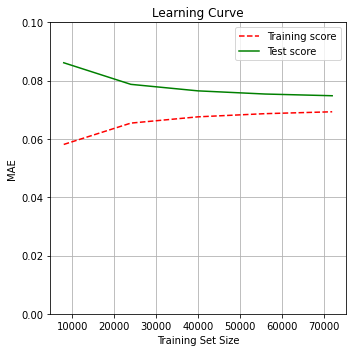

In [173]:
train_scores1 = np.abs(train_scores1)
valid_scores1 = np.abs(valid_scores1)

train_mean1 = np.mean(train_scores1, axis=1)
train_std1 = np.std(train_scores1, axis=1)

valid_mean1 = np.mean(valid_scores1, axis=1)
valid_std1 = np.std(valid_scores1, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes1, train_mean1, '--', color="r",  label="Training score")
plt.plot(train_sizes1, valid_mean1, color="g", label="Test score")



plt.grid()
plt.ylim(0,0.1)
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("MAE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

5.1.2 Curvas de aprendizaje para Random Forest Regresor

In [174]:
Rdm_forest1 = RandomForestRegressor(n_estimators = 25,max_depth = 15)
train_sizes2, train_scores2, valid_scores2 = learning_curve(Rdm_forest1, Xtv, ytv, train_sizes= [0.1, 0.3, 0.5, 0.7, 0.9], 
                 scoring ='neg_mean_absolute_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

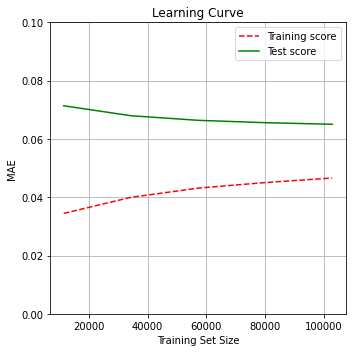

In [176]:
train_scores2 = np.abs(train_scores2)
valid_scores2 = np.abs(valid_scores2)

train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)

valid_mean2 = np.mean(valid_scores2, axis=1)
valid_std2 = np.std(valid_scores2, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes2, train_mean2, '--', color="r",  label="Training score")
plt.plot(train_sizes2, valid_mean2, color="g", label="Test score")



plt.grid()
plt.ylim(0,0.1)
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("MAE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

###5.2 Modelos no supervisados

5.2.1 PCA con Random Forest

In [179]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
X_t2 = pca.fit_transform(X2)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y2, test_size=test_size)

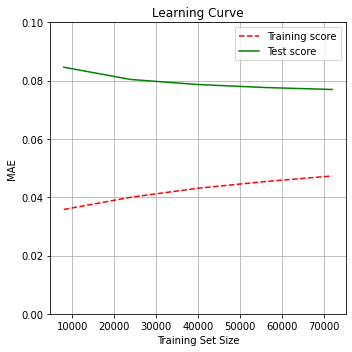

In [180]:
Rdm_forest1 = RandomForestRegressor(n_estimators = 25,max_depth = 15)
train_sizes3, train_scores3, valid_scores3 = learning_curve(Rdm_forest1, Xtv, ytv, train_sizes= [0.1, 0.3, 0.5, 0.7, 0.9], 
                 scoring ='neg_mean_absolute_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

train_scores3 = np.abs(train_scores3)
valid_scores3 = np.abs(valid_scores3)

train_mean3 = np.mean(train_scores3, axis=1)
train_std3 = np.std(train_scores3, axis=1)

valid_mean3 = np.mean(valid_scores3, axis=1)
valid_std3 = np.std(valid_scores3, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes3, train_mean3, '--', color="r",  label="Training score")
plt.plot(train_sizes3, valid_mean3, color="g", label="Test score")



plt.grid()
plt.ylim(0,0.1)
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("MAE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

5.2.2 NMF con Random Forest

In [181]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 3)
X_t3 = nmf.fit_transform(X3)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y3, test_size=test_size)

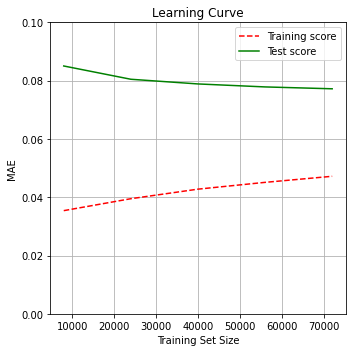

In [182]:
Rdm_forest2 = RandomForestRegressor(n_estimators = 25,max_depth = 15)
train_sizes4, train_scores4, valid_scores4 = learning_curve(Rdm_forest2, Xtv, ytv, train_sizes= [0.1, 0.3, 0.5, 0.7, 0.9], 
                 scoring ='neg_mean_absolute_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

train_scores4 = np.abs(train_scores4)
valid_scores4 = np.abs(valid_scores4)

train_mean4 = np.mean(train_scores4, axis=1)
train_std4 = np.std(train_scores4, axis=1)

valid_mean4 = np.mean(valid_scores4, axis=1)
valid_std4 = np.std(valid_scores4, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes4, train_mean4, '--', color="r",  label="Training score")
plt.plot(train_sizes4, valid_mean4, color="g", label="Test score")



plt.grid()
plt.ylim(0,0.1)
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("MAE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()